# multiway CCA
This notebook contains testing code for multi-way CCA based learning using a parafac tensor decomposition in the algorithm core, rather than a SVD

In [3]:
import numpy as np
from mindaffectBCI.decoder.offline.datasets import get_dataset
from mindaffectBCI.decoder.model_fitting import MultiCCA
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised
from mindaffectBCI.decoder.utils import block_permute
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mindaffectBCI.decoder.analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load example data
dataset_loader, files, dataroot = get_dataset('plos_one', regexp='s3')
evttypes=('re','fe')
tau_ms = 450

In [4]:
# level threshold - single outputs with multiple levels
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/khash",regexp='vep_threshold')
evttypes='hot-on'
tau_ms = 550

In [5]:
# visual - acuity - multiple outputs at the same time.
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/mark",regexp='vep_threshold_scale')
evttypes='hot-on'
tau_ms = 550

In [177]:
# visual - acuity - multiple outputs at the same time.
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/mark",regexp='visual_acuity')
evttypes='output2event'
tau_ms = 550

In [178]:
# the data
savefile = files[-1]
X,Y,coords = dataset_loader(savefile)
oY  = Y.copy()
oX  = X.copy()
fs=coords[1]['fs']
ch_names=coords[-1]['coords']

Loading C:\Users\Developer/Desktop/mark\mindaffectBCI_visual_acuity_201210_1559.txt
X=(139044, 8) @250.5637684790779Hz
preFilter: 6th butter ((45, 65), (5.5, 25, 'bandpass'))Hz & downsample 250.5637684790779->100Hz
resample: 250.5637684790779->100.22550739163117hz rsrate=2.5
Y=(55618, 37) @100.22550739163117Hz
60 trl_dur (ms) : [3999. 4000. 4000. 4000. 4000. 4000. 3999. 4000. 4000. 4000. 3999. 4016.
 4000. 3999. 4016. 3999. 3999. 4000. 4183. 4016. 4014. 4017. 4000. 4016.
 4016. 3999. 4016. 4016. 4016. 4016. 4050. 4000. 3999. 3999. 4000. 4016.
 4000. 4002. 4082. 4084. 4000. 4067. 3999. 4150. 3999. 3999. 4083. 3999.
 4133. 4006. 4000. 3999. 3999. 4016. 4000. 4143. 4049. 4000. 4000. 3999.]
61 trl_stim : [array([241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241,
       241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241,
       241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241,
       241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241,
 

In [179]:
# dataset specific pre-processing..
if 'visual_acuity' in savefile: # strip the calibration trials as they have a different meaning for objID==1
    print('Stripping first 10 trials')
    X = oX[10:,...] 
    Y = oY[10:,...,1:]
elif 'threshold' in savefile:
    print('Stripping first 10 trials')
    X = oX[10:,...] 
    Y = oY[10:,...,1:]
    print("Adding virtual outputs")
    # add virtual outputs so always at least 30 outputs so we can test the decoding performance
    Y = np.concatenate((Y, block_permute(Y, -30, axis=-1)), -1) # (..., nY)
    Y.shape

Stripping first 10 trials


EEG: X(['trial', 'time', 'channel'])(50, 509, 8) @100.22550739163117Hz
STIMULUS: Y(['trial', 'time', 'output'])(50, 509, 36)


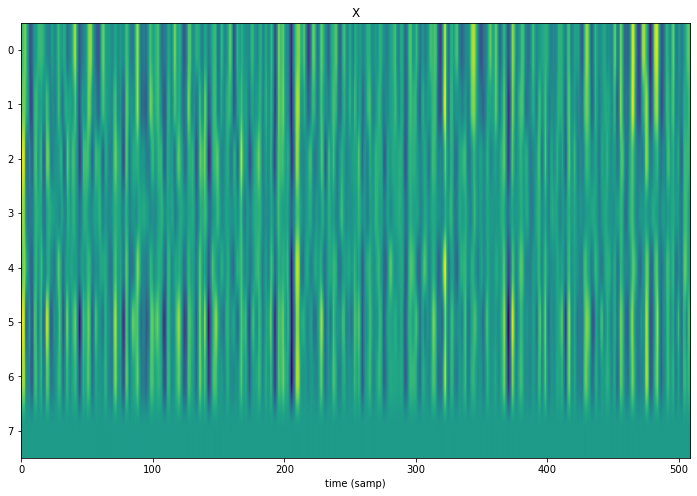

Text(0.5, 1.0, 'Y')

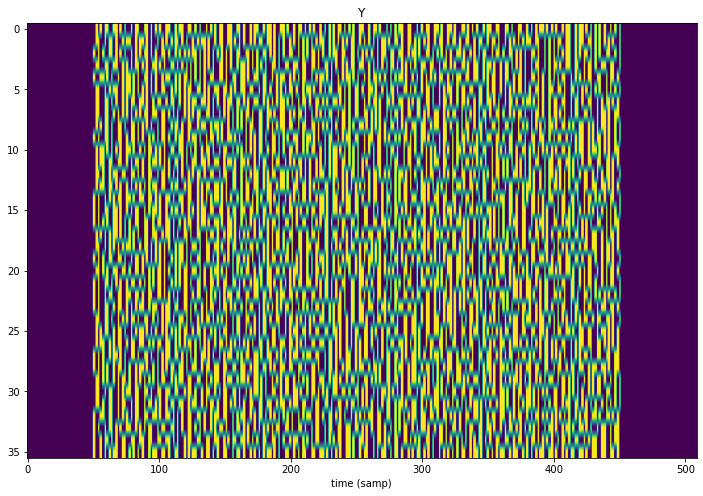

In [180]:
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y.shape))
plt.imshow(X[0,:,:].T,aspect='auto');plt.xlabel('time (samp)');plt.title('X');plt.show()
plt.imshow(Y[0,:,:].T,aspect='auto');plt.xlabel('time (samp)');plt.title('Y')

Evtlabs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
X=(50, 509, 8)
Y_true=(50, 509, 1, 36)


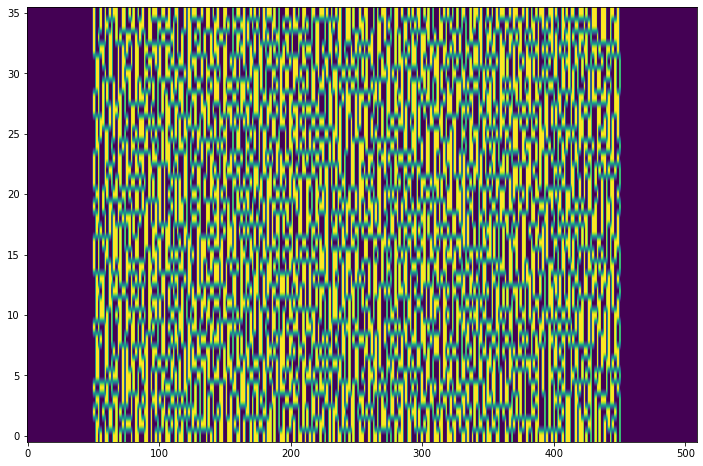

In [181]:
# get the true-label and convert to brain-response
from stim2event import stim2event
# map to event sequence, for rising/falling edges
Ye,evtlabs = stim2event(Y,evtypes=evttypes,axis=-2) # (tr,samp,nY,e)
print("Evtlabs: {}".format(evtlabs))
# extract the true target to fit to, using horible slicing trick
Ye_true = Ye[..., 0:1, :] #  (tr,samp,1,e)
print("X={}".format(X.shape))
print("Y_true={}".format(Ye_true.shape))
plt.imshow(Ye_true[0,:,0,:].T,aspect='auto',origin='normal')

Cxx=(8, 8)
Cxy=(1, 36, 55, 8)
Cyy=(1, 36, 55, 36, 55)


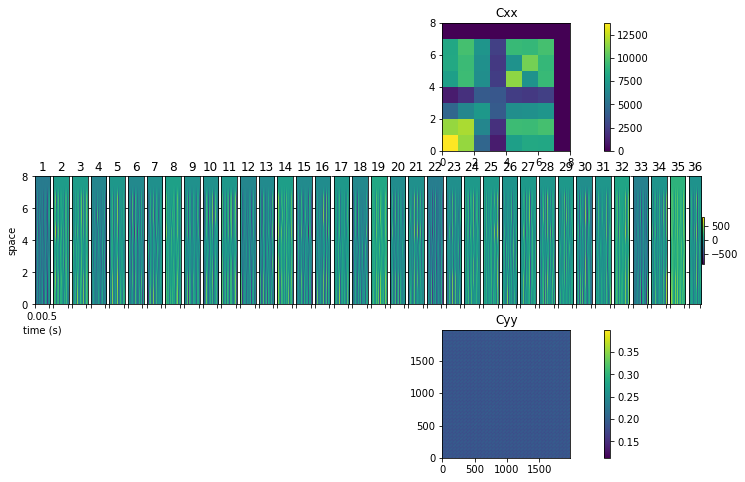

In [182]:
# get the summary statistics
from updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics
tau = tau_ms * fs // 1000 # ms->samples
Cxx, Cxy, Cyy = updateSummaryStatistics(X, Ye_true, tau=tau)
print("Cxx={}".format(Cxx.shape))
print("Cxy={}".format(Cxy.shape))
print("Cyy={}".format(Cyy.shape))
plot_summary_statistics(Cxx, Cxy, Cyy, evtlabs=evtlabs, fs=fs, ch_names=ch_names)

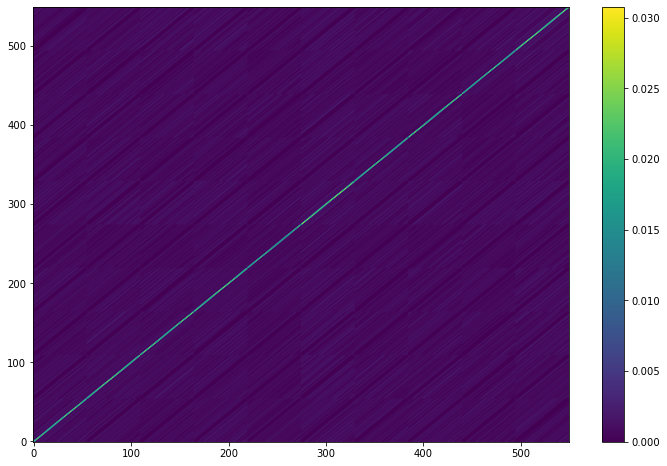

In [33]:
plt.imshow(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto',origin='normal');plt.colorbar()

In [34]:
rank=2

A=(2, 8) R=(2, 10, 55)


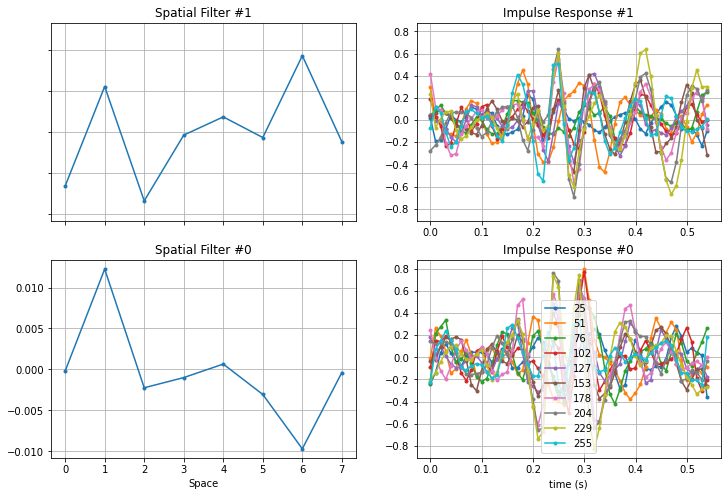

Int Lens:..............................

            IntLen   146   293   404   551   697   808   955  1102 
              Perr  0.58  0.40  0.20  0.08  0.00  0.00  0.00  0.00   AUDC 21.9
         Perr(est)  0.51  0.32  0.22  0.12  0.05  0.02  0.02  0.02   PSAE 26.3
           StopErr  0.66  0.24  0.10  0.08  0.08  0.08  0.08  0.08   AUSC 23.3
     StopThresh(P)  0.47  0.13  0.06  0.03  0.03  0.03  0.03  0.03   SSAE 41.6



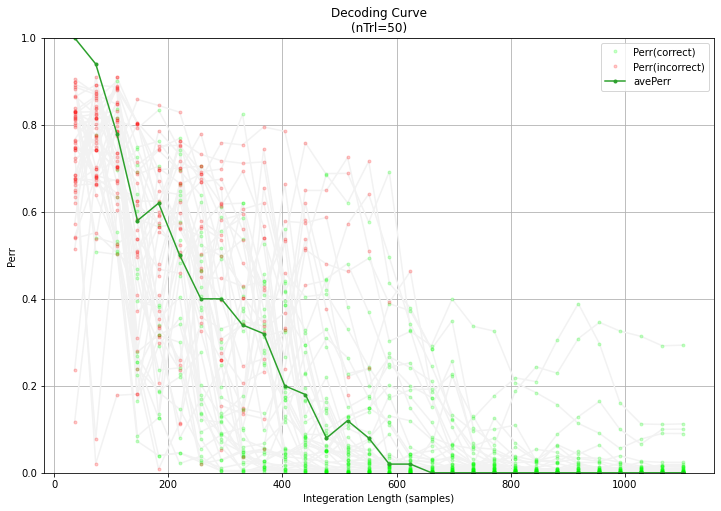

In [35]:
from multipleCCA import multipleCCA, robust_whitener
from updateSummaryStatistics import plot_factoredmodel
# run and plot the normal CCA model
J, W, R = multipleCCA(Cxx, Cxy, Cyy, reg=.02, rank=rank)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()
# eval this models performance
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Ye, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)

In [36]:
# Now try with the tensor factored version..

Text(0.5, 1.0, 'Whitened: Cxx')

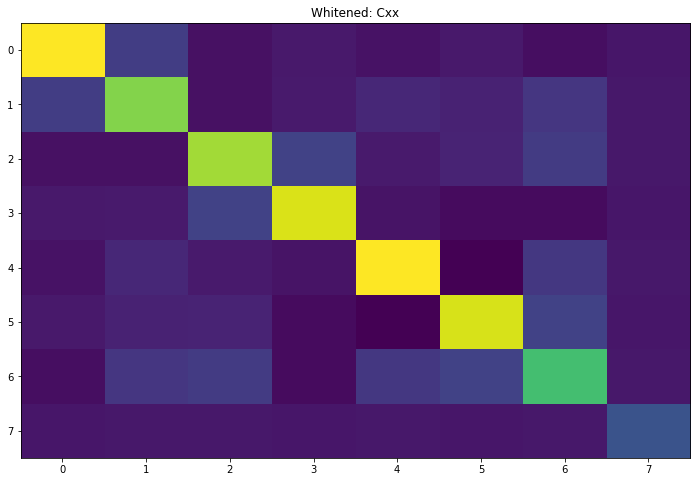

In [37]:
# 1. X spatial whitener
from multipleCCA import robust_whitener
Wx, iWx = robust_whitener(Cxx,reg=.02)

wCxxw = np.einsum("de,df,eg",Cxx,Wx,Wx)
plt.imshow(wCxxw,aspect='auto');plt.title('Whitened: Cxx')

In [38]:
# 2.Cyy combined whitener..
#  Cyy = (nM,e,tau,e,tau)
Wy, iWy = robust_whitener(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),reg=.02) # (e*tau,e*tau)
Wy = Wy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)
iWy = iWy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)

In [39]:
# 2. Y temporal whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_tau = np.sum(Cyy,axis=(0,1,3))
#plt.imshow(Cyy_tau,aspect='auto');plt.title('Cyy_tau');plt.colorbar();plt.show()
Wy_tau, iWy_tau = robust_whitener(Cyy_tau,reg=.0)

#wtauCyy_tauwtau = np.einsum("tu,tv,uw",Cyy_tau,Wy_tau,Wy_tau)
#plt.imshow(wtauCyy_tauwtau,aspect='auto');plt.title('Whitended: Cyy_tau');plt.colorbar();plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [40]:
# 2. Y event whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_e = np.sum(Cyy,axis=(0,2,4))
Wy_e, iWy_e = robust_whitener(Cyy_e,reg=.02)

#weCyy_ewe = np.einsum("ed,ef,dg",Cyy_e,Wy_e,Wy_e)
#plt.imshow(weCyy_ewe,aspect='auto');plt.title('Whitended: Cyy_tau');plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [59]:
def plotCxy(Cxy, evtlabs=None, fs=None):
    times = np.arange(Cxy.shape[-2])
    if fs is not None: times = times/fs
    fit,ax = plt.subplots(nrows=1,ncols=Cxy.shape[1],sharey='row')
    for ei in range(Cxy.shape[1]):
        plt.sca(ax[ei])
        plt.imshow(Cxy[0,ei,:,:],aspect='auto',extent=[0,times[-1],0,Cxy.shape[-1]])
        if evtlabs is not None: plt.title(evtlabs[ei])

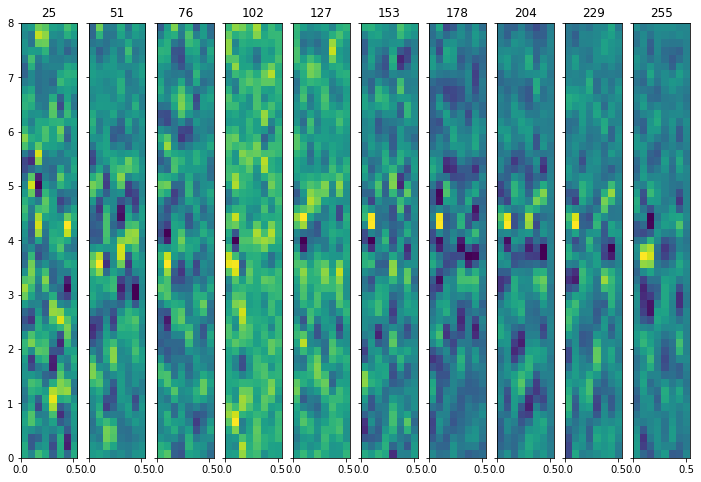

In [60]:
# apply the spatial whiteners
WxCxy = np.einsum("metd,df->metf",Cxy,Wx)
plotCxy(WxCxy,evtlabs,fs)

In [89]:
# set factored/nonfactored
isFactored = False

WxCxyWy (1, 10, 55, 8)


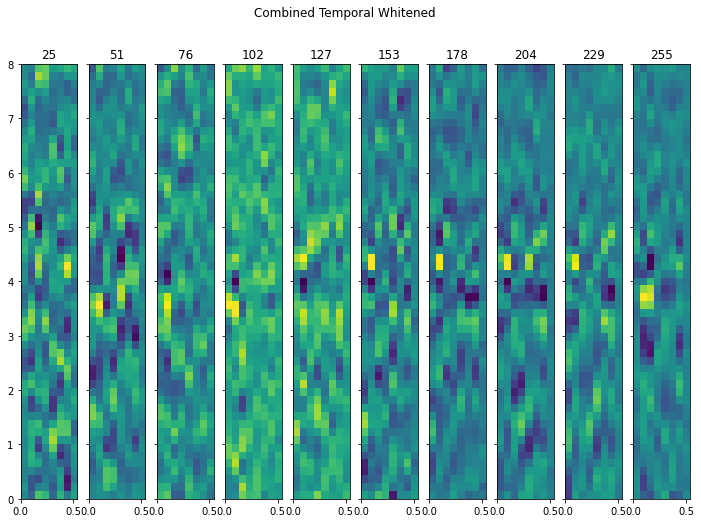

In [90]:
# total-temporal-whitener
if not isFactored:
    WxCxyWy_t = np.einsum("metd,etgu->mgud",WxCxy,Wy)

    print("WxCxyWy {}".format(WxCxyWy_t.shape))
    plotCxy(WxCxyWy_t,evtlabs,fs); plt.suptitle("Combined Temporal Whitened")

In [91]:
# factored-whitener
if isFactored:
    WxCxyWy_f = np.einsum("metd,eg,tu->mgud",WxCxy,Wy_e,Wy_tau)

    print("WxCxyWy {}".format(WxCxyWy_f.shape))
    plotCxy(WxCxyWy_f,evtlabs,fs); plt.suptitle("Factored Temporal Whitened")

ten=(10, 55, 8)


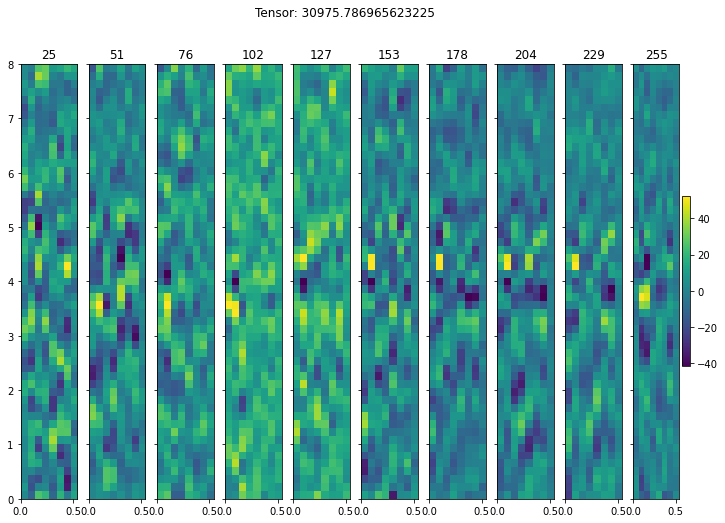

Decomp=(10, 3),(55, 3),(8, 3)
w=[1. 1. 1.]
recons=(10, 55, 8)


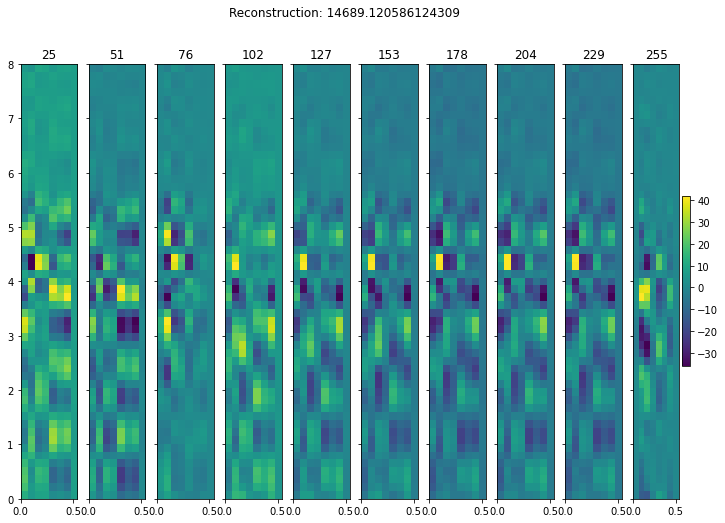

|W|=30975.786965623225 |parafac|=14689.120586124309


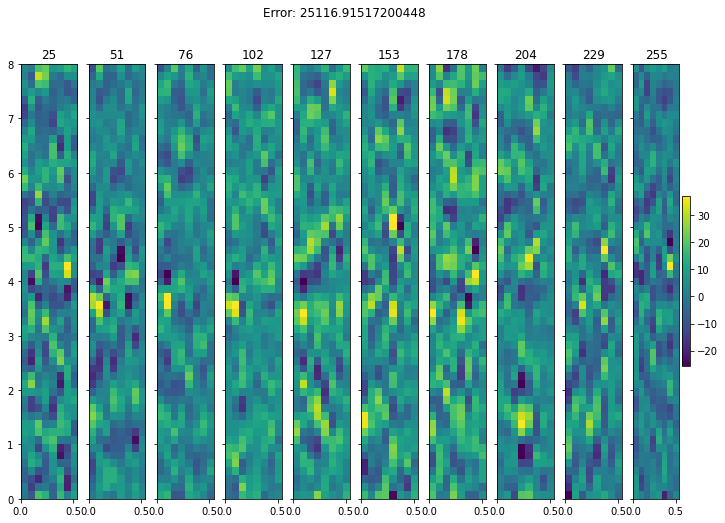

|err|=25116.91517200448


In [170]:
# CD/PARAFAC decomp
from tensorly.decomposition import parafac
if isFactored: 
    ten = WxCxyWy_f[0,...]
else:
    ten = WxCxyWy_t[0,...]
print("ten={}".format(ten.shape))
normW = np.sum(np.abs(ten.ravel()))
plotCxy(ten[np.newaxis,...],evtlabs,fs); plt.colorbar();plt.suptitle("Tensor: {}".format(normW)); plt.show()
kruskal_decomp = parafac(ten, rank=3, normalize_factors=False)#True)
weight = kruskal_decomp[0]
factors = kruskal_decomp[1]
print("Decomp={},{},{}".format(*[f.shape for f in factors]))
We = factors[0]
Wt = factors[1]
Wd = factors[2]
print("w={}".format(weight))

# check the reconstruction error
from tensorly import kruskal_to_tensor
recons = kruskal_to_tensor(kruskal_decomp)
normRecons = np.sum(np.abs(recons.ravel()))
print('recons={}'.format(recons.shape))
plotCxy(recons[np.newaxis,...],evtlabs,fs); plt.colorbar(); plt.suptitle("Reconstruction: {}".format(normRecons)); plt.show()
err = np.sum(np.abs(ten.ravel()-recons.ravel()))
print('|W|={} |parafac|={}'.format(normW,normRecons,err))

plotCxy((ten-recons)[np.newaxis,...],evtlabs,fs); plt.colorbar(); plt.suptitle("Error: {}".format(err)); plt.show()
print('|err|={}'.format(err))


Text(0.5, 0.98, 'hreshold_scale_201216_1503.txt evttypes=hot-on')

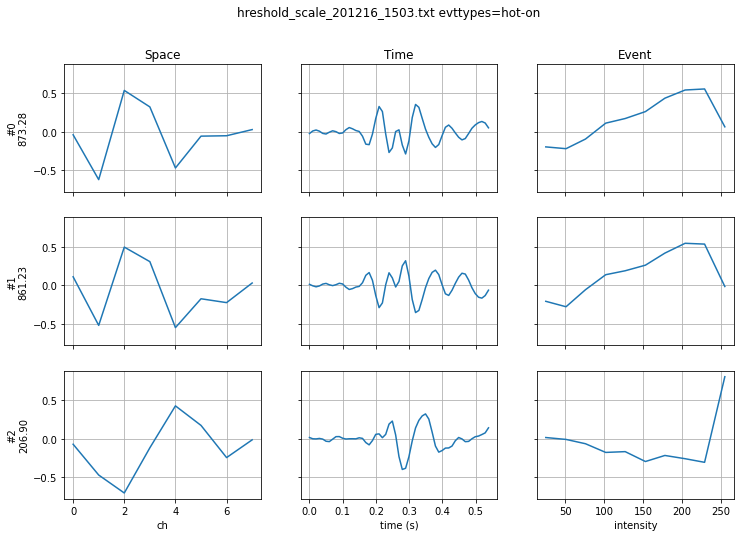

In [172]:
# plot the decomp: e,t,d x rank
ch_names = np.arange(Wd.shape[0]) if ch_names is None else ch_names
times = np.arange(Wt.shape[0])/fs
evts = evtlabs
fig, axes = plt.subplots(nrows=We.shape[1],ncols=3,sharex='col',sharey=True)
if axes.ndim<2: axes=axes[np.newaxis,:]
for r in range(We.shape[1]):
    sgn = np.sign(We[:,r].flat[abs(We[:,r]).argmax()]) # normalize size of the event weighting
    wght = weight[r]*np.sqrt(np.sum(Wd[:,r]**2))*np.sqrt(np.sum(Wt[:,r]**2))*np.sqrt(np.sum(We[:,r]**2))
    plt.sca(axes[r,0]); plt.plot(ch_names, Wd[:,r]/np.sqrt(np.sum(Wd[:,r]**2))); plt.grid();  plt.ylabel('#{}\n{:3.2f}'.format(r,wght))
    if r==0: plt.title('Space');
    elif r==We.shape[1]-1: plt.xlabel('ch')
    plt.sca(axes[r,1]); plt.plot(times,    sgn*Wt[:,r]/np.sqrt(np.sum(Wt[:,r]**2))); plt.grid(); 
    if r==0: plt.title('Time') 
    elif r==We.shape[1]-1: plt.xlabel('time (s)')
    plt.sca(axes[r,2]); plt.plot(evts,     sgn*We[:,r]/np.sqrt(np.sum(We[:,r]**2))); plt.grid(); 
    if r==0: plt.title('Event')
    elif r==We.shape[1]-1: plt.xlabel('intensity') 
plt.suptitle("{} evttypes={}".format(files[-1][-30:],evttypes))

trying to get pos from cap file!
A=(3, 8) R=(3, 10, 55)


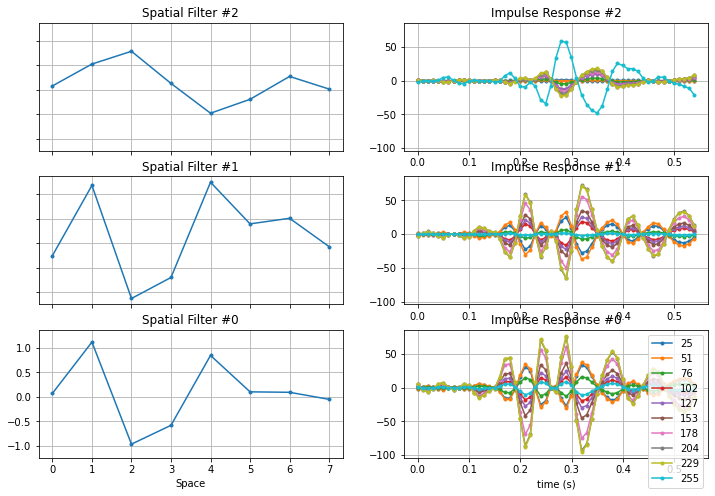

In [173]:
# make equivalent to the multiCCA outputs (so can re-use apply methods)
W = Wd.T # (rank,d)
R = np.einsum("tk,ek->ket",Wt,We) # (rank,e,tau)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()

In [174]:
# apply the spatial whitener
W = W @ iWx # (d,rank)

In [175]:
# include the temporal whitener
if isFactored:
    R = np.einsum("ket,ef,tu->kfu",R,iWy_e,iWy_tau)
else:
    R = np.einsum("ket,etfu->kfu",R,iWy)

Int Lens:..............................

            IntLen   146   293   404   551   697   808   955  1102 
              Perr  0.70  0.38  0.32  0.26  0.10  0.04  0.00  0.00   AUDC 27.4
         Perr(est)  0.49  0.33  0.23  0.17  0.13  0.08  0.05  0.04   PSAE 33.4
           StopErr  0.76  0.28  0.24  0.08  0.08  0.08  0.08  0.08   AUSC 26.3
     StopThresh(P)  0.41  0.13  0.11  0.05  0.05  0.05  0.05  0.05   SSAE 36.6



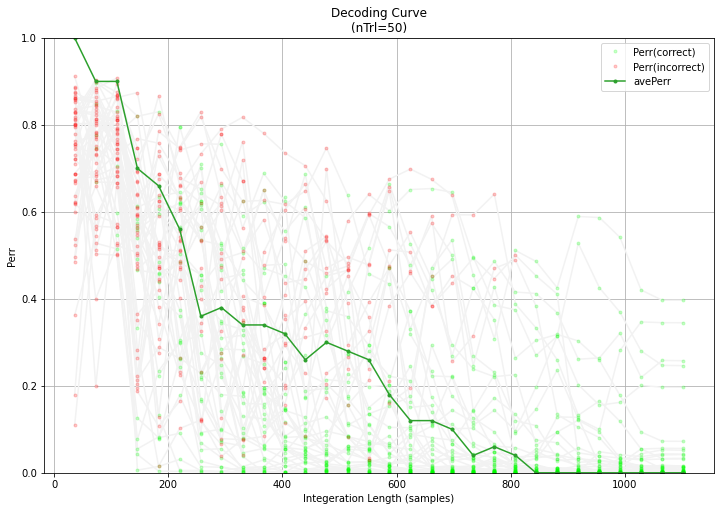

In [176]:
# apply to the data
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Ye, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)